In [3]:
# Useful / Necessary imports
import pandas as pd
import numpy as np
import statsmodels.api as sm
import csv
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, precision_score, recall_score
import warnings;

import seaborn as sns

warnings.filterwarnings('ignore');

In [4]:
# Read the CSV and drop rows that are from older years
# in order to make the dataset more manageable and current.
# Only dropping rows from 2016/17, and this cell should only need
# to be run one time to create the cleaned data file.

with open('US_Accidents_Dec21_updated.csv', 'r') as inp, open('accidents_cleaned.csv', 'w') as out:
    writer = csv.writer(out)
    reader = csv.reader(inp)
    
    # skip the header row
    writer.writerow(next(reader))
    
    for row in reader:
        if "2021" in row[2] or "2020" in row[2] or "2019" in row[2] or "2018" in row[2]:
            writer.writerow(row)

In [5]:
# Load the dataset, this cell might take a minute to finish
# execution due to large size of the csv file.
accidents = pd.read_csv("accidents_cleaned.csv")

In [6]:
# Clean the dataset by dropping unnecessary columns
drop = ["Start_Lat", "Start_Lng", "End_Lat", "End_Lng",
        "Timezone", "Airport_Code", "Number", "Description"]

accidents.drop(columns=drop, inplace=True)

# Convert time columns to datetime formats
accidents['Start_Time'] = pd.to_datetime(accidents['Start_Time'])
accidents['End_Time'] = pd.to_datetime(accidents['End_Time'])
accidents['Weather_Timestamp'] = pd.to_datetime(accidents['Weather_Timestamp'])

In [ ]:
# Examine the dataset to determine if it needs to be cleaned in any way.
# We are looking for duplicate rows, NaN/null values, and incorrect data types.

print("----------------------- Examine Data for Cleaning -----------------------")
print()

# Starting with data types...
print("Data types for each column in the dataset:")
print(accidents.dtypes)
print()

# Duplicate rows
print("Number of duplicated rows in the dataset:")
print(accidents.duplicated().sum())
print()

# Null values
print("Number of null values in the dataset:")
print(accidents.isnull().sum())

print()
print("-------------------------------------------------------------------------")

In [ ]:
# Continue to clean the dataset by removing rows with missing values
# Drop rows with null values, using column names printed above
accidents.dropna(subset = ['Street', 'City', 'Zipcode', 'Weather_Timestamp', 'Temperature(F)',
                    'Wind_Chill(F)', 'Humidity(%)', 'Pressure(in)', 'Visibility(mi)',
                    'Wind_Direction', 'Wind_Speed(mph)', 'Precipitation(in)', 'Weather_Condition',
                    'Sunrise_Sunset', 'Civil_Twilight', "Nautical_Twilight", "Astronomical_Twilight"],
                 inplace = True)

# Now reprint the count of null values
print("Number of null values in the dataset:")
print(accidents.isnull().sum())

In [ ]:
# Continue the cleaning process yet again by converting the catagorical
# variables in the dataset into integer values so that they can run in
# the regression model that we will create
LE = LabelEncoder()
accidents = accidents.apply(LE.fit_transform)

In [ ]:
# Now that the data is cleaned, we can start building the regression model

# Using a logistic regression model from the statsmodels api will allow
# us to determine which features are most effective at making predictions
# about the servarity of an accident.

# Split the dataset into testing and training data
# We can ignore the ID since it won't have any weight
# on the decision maxing process
features = ["Start_Time", "End_Time", "Distance(mi)", "Street", "Side", "City",
            "County", "State", "Zipcode", "Country", "Weather_Timestamp",
            "Temperature(F)", "Wind_Chill(F)", "Humidity(%)",
            "Pressure(in)", "Visibility(mi)", "Wind_Direction", "Wind_Speed(mph)",
            "Precipitation(in)", "Weather_Condition", "Amenity", "Bump", "Crossing",
            "Give_Way", "Junction", "No_Exit", "Railway", "Roundabout", "Station",
            "Stop", "Traffic_Calming", "Traffic_Signal", "Turning_Loop", "Sunrise_Sunset",
            "Civil_Twilight", "Nautical_Twilight", "Astronomical_Twilight"]

X = accidents.loc[:, features]
y = accidents.loc[:, 'Severity']

train_vectors, test_vectors, train_labels, test_labels = train_test_split(X, y, random_state=123, train_size=.75)

In [9]:
# Construct the model using the training labels and vectors
# fit the model and print the summary so that we can evaluate
# the different features based on their P scores
ols_model = sm.OLS(train_labels, sm.add_constant(train_vectors))
result = ols_model.fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:               Severity   R-squared:                       0.077
Model:                            OLS   Adj. R-squared:                  0.077
Method:                 Least Squares   F-statistic:                     3900.
Date:                Tue, 18 Apr 2023   Prob (F-statistic):               0.00
Time:                        04:11:59   Log-Likelihood:            -6.7101e+05
No. Observations:             1647273   AIC:                         1.342e+06
Df Residuals:                 1647237   BIC:                         1.343e+06
Df Model:                          35                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     1.68

In [10]:
# Now that we have an initial summary, we can drop factors that don't have much of
# an affect on the correlation to the severity of an accident, as well as calculate
# some basic statistics and metrics to determine the strength of the initial model

# Remove the weak features and resplit the data.
# Features being dropped are: Bump, No_Exit, Roundabout, Traffic_Calming,
# Turning_Loop, and Civil_Twilight.
features = ["Start_Time", "End_Time", "Distance(mi)", "Street", "Side",
            "City", "County", "State", "Zipcode", "Country", "Weather_Timestamp",
            "Temperature(F)", "Wind_Chill(F)", "Humidity(%)", "Pressure(in)",
            "Visibility(mi)", "Wind_Direction", "Wind_Speed(mph)",
            "Precipitation(in)", "Weather_Condition", "Amenity", "Crossing",
            "Give_Way", "Junction", "Railway", "Station", "Stop", "Traffic_Signal",
            "Sunrise_Sunset", "Nautical_Twilight", "Astronomical_Twilight"]

X = accidents.loc[:, features]
y = accidents.loc[:, 'Severity']

train_vectors, test_vectors, train_labels, test_labels = train_test_split(X, y, random_state=123, train_size=.75)

# Reconstruct the model with the new data
refined_ols_model = sm.OLS(train_labels, sm.add_constant(train_vectors))
refined_result = refined_ols_model.fit()

# Calculate the precision, recall and accuracy
values = refined_result.predict(sm.add_constant(test_vectors))
predictions = np.where(values > 0.5, 1, 0)

p_score = precision_score(test_labels, predictions, average='weighted')
r_score = recall_score(test_labels, predictions, average='weighted')

print("----------------------- Initial Evaluation -----------------------\n")
print(f"Precision: {p_score}")
print(f"Recall: {r_score}")

correct = 0
total_samples = len(test_labels)

temp = np.array(test_labels)
for i in range(len(test_labels)):
    if predictions[i] == temp[i]:
        correct += 1

accuracy = correct / total_samples

print(f"Accuracy: {accuracy}")
print("\n------------------------------------------------------------------")

----------------------- Initial Evaluation -----------------------

Precision: 0.8703468329524682
Recall: 0.9329238087606448
Accuracy: 0.9329238087606448

------------------------------------------------------------------


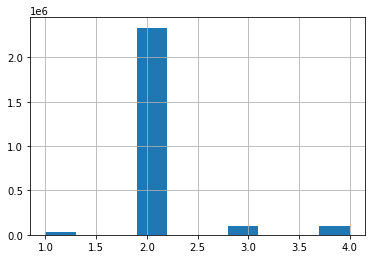

In [61]:
accidents['Severity'].hist()
plt.show()

In [7]:
accidents['Temperature(F)'].describe()

count    2.496394e+06
mean     6.157971e+01
std      1.863880e+01
min     -8.900000e+01
25%      4.900000e+01
50%      6.300000e+01
75%      7.600000e+01
max      1.960000e+02
Name: Temperature(F), dtype: float64

In [8]:
#from the .describe(), it shows that there are outliers in the accidents data so I took sample
#of the large data to minimize possible outliers 

sample = accidents.sample(n=1000)
sample['Temperature(F)'].describe()

count    975.000000
mean      59.843179
std       18.791405
min      -10.000000
25%       47.000000
50%       61.000000
75%       74.000000
max      109.000000
Name: Temperature(F), dtype: float64

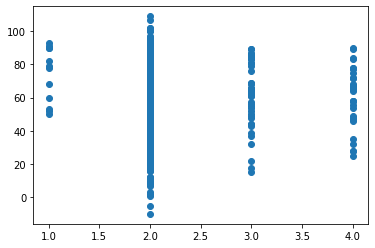

In [9]:
severity = sample['Severity']
temperature = sample['Temperature(F)']

plt.scatter(severity,temperature)

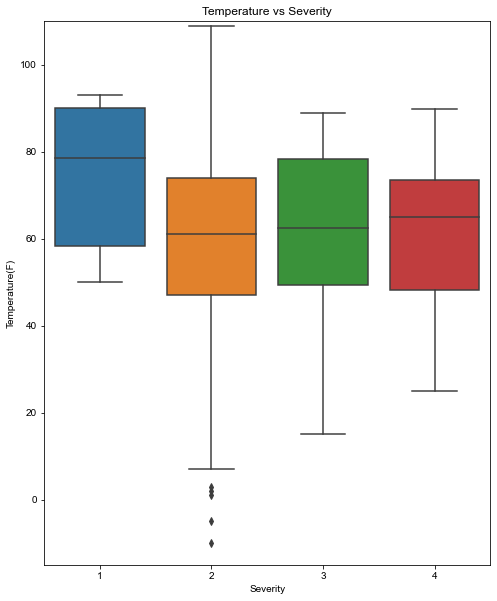

In [12]:
plt.figure(figsize=(8,10))
sns.boxplot(data=sample, y='Temperature(F)', x='Severity').set_title('Temperature vs Severity')
sns.set_style("whitegrid")

plt.ylim(-15, 110)
plt.show()

In [13]:
sample['Wind_Chill(F)'].describe()

count    906.000000
mean      58.401876
std       21.231199
min      -23.000000
25%       45.000000
50%       61.000000
75%       74.000000
max      109.000000
Name: Wind_Chill(F), dtype: float64

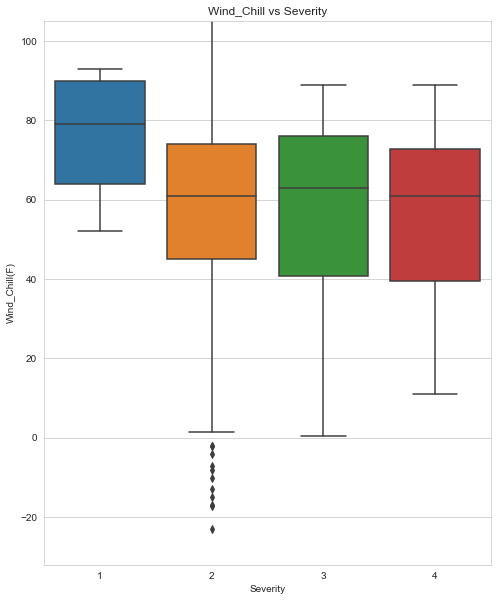

In [16]:
plt.figure(figsize=(8,10))
sns.boxplot(data=sample, y='Wind_Chill(F)', x='Severity').set_title('Wind_Chill vs Severity')
sns.set_style("whitegrid")

plt.ylim(-32, 105)
plt.show()

In [11]:
# I temporarily commented these cells out because I don't have the 'cleaned.csv'
# file that is used for the accidents_2 DataFrame

# TODO: Recconcile tomorrow in class so I can make sure I have the right data

# accidents_2 = pd.read_csv('cleaned.csv')
# accidents_2

In [12]:
#Finding effect of time of day on the number of accidents

# day_accidents = accidents[accidents['Sunrise_Sunset']=='Day']
# night_accidents = accidents[accidents['Sunrise_Sunset']=='Night']

# day_accidents_2 = accidents_2[accidents_2['Light_conditions']=='Daylight']
# night_accidents_2 = accidents_2[accidents_2['Light_conditions']=='Darkness - lights lit'] + accidents_2[accidents_2['Light_conditions']=='Darkness - lights unlit'] + accidents_2[accidents_2['Light_conditions']=='Darkness - no lighting']

# day_num = len(day_accidents)+len(day_accidents_2)
# night_num = len(night_accidents)+len(night_accidents_2)
# time_of_day =['Day', 'Night']
